In [68]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import IPython.html.widgets as widgets
from IPython.html.widgets import interactive
from IPython.display import display

<h1 style="text-decoration: underline, overline; color: navy;">Rapport de stage</h1>

<h2 style="text-decoration: underline;">Partie I : Robot controlé par DNF</h2>

Le but de cette première partie de stage consiste à utiliser des champs neuronaux dynamiques (ou DNF : Dynamic Neural Fields), c'est à dire plusieurs éléments permettant un calcul décentralisé et distribué avec un comportement émergent face à un stimulis extérieur, pour permettre l'élaboration d'un robot autonome capable d'éviter des obstacles.

Pour cette première expérience le modèle de robot utilisé sera un e-puck : un petit robot cylindrique avec des capteurs infrarouges tout autour de lui et une caméra. Les stimulis extérieurs seront donc pour cette première partie les capteurs de proximité infrarouge.

###I. Théorie et calculs

####1) DNF

Les champs neuronaux dynamiques sont directement reliés aux capteurs infrarouges puis pour savoir quel angle semble le plus suceptible d'être un obstacle, on va utiliser l'activation du DNF qui va renvoyer 0 si rien n'est détecté ou une valeur positive sinon.

Sur le schéma suivant, l'intensité du capteur a été multiplié par 100. L'intensité du capteur est égal à la distance maximale de réception moins la distance actuele détectée. Elle varie donc de 0 à 0.04 m.

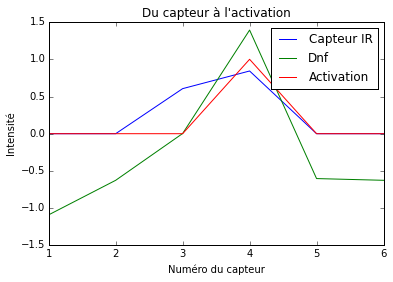

In [40]:
x = np.array([1, 2, 3, 4, 5, 6])
ir = np.array([0.000000000000000000e+00,
0.000000000000000000e+00,
6.056077528688350031e-03,
8.428876313973869550e-03,
0.000000000000000000e+00,
0.000000000000000000e+00])
ir=ir*100
dnf = np.array([-1.090321063995361328e+00,
-6.263688206672668457e-01,
2.505307266418066447e-03,
1.392887643318315938e+00,
-6.031024456024169922e-01,
-6.263688206672668457e-01])
activation = np.array([0,0,0,1,0,0])

plt.plot(x,ir,label='Capteur IR')
plt.plot(x,dnf,label='Dnf')
plt.plot(x,activation,label='Activation')
plt.legend()
plt.xlabel("Numéro du capteur")
plt.ylabel("Intensité")
plt.title("Du capteur à l'activation")
plt.show()

####2) Moyenne pondérée

Mais l'activation n'étant pas une valeur mais une courbe, il faut d'abord en tirer une valeur intéressante et situé entre $-\frac{\Pi}{2}$ et $\frac{\Pi}{2}$. Pour cela, nous avons fait la moyenne pondérée des angles par le poids de l'activation.
C'est à dire $\frac{\sum{\phi_i V_i}}{\sum{V_i}}$ avec $\phi_i$ les angles de chaques capteur et $V_i$ l'activation i.

####3) Vitesses des roues

Si jamais il y a une quelconque activation entre $-\frac{\Pi}{2}$ et $\frac{\Pi}{2}$ alors la vitesse des roues va être modifiées selon la loi suivante pour la roue gauche :
$\frac{3}{1+e^{(\phi*5)}}-1.5$ avec $\phi$ l'angle entre le robot et l'obstacle.
<p>Et symétriquement dans le cas de la roue droite.</p>

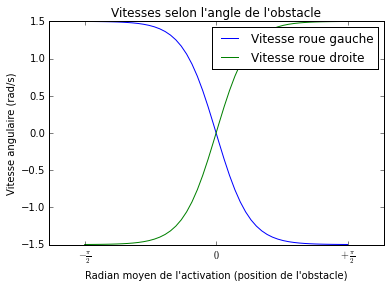

In [49]:
x, st = np.linspace(-math.pi/2,math.pi/2, retstep=True)
vL = 3/(1+np.exp(x*5))-1.5
vR = 3/(1+np.exp(-x*5))-1.5
plt.plot(x,vL,label='Vitesse roue gauche')
plt.plot(x,vR,label='Vitesse roue droite')
plt.legend()
plt.xlabel("Radian moyen de l'activation (position de l'obstacle)")
plt.ylabel("Vitesse angulaire (rad/s)")
plt.title("Vitesses selon l'angle de l'obstacle")
plt.xticks([-math.pi/2, 0, math.pi/2], [r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$'])
plt.show()


Pour vérifier le bon fonctionnement dynamique de la formule face à un obstacle, observons $\frac{d\psi}{dt} = \omega$ en fonction de $\psi$, l'angle du robot dans le repère absolu.

Nous connaissons la taille de l'axe des deux roues ($\Delta = 52 mm$) et le rayon des roues ($r = 20.5 mm$).
On en déduit que face à un obstacle $\omega =\frac{r}{\Delta}(v_d-v_g)= \frac{2r}{\Delta}v_d$ avec $v_d = -v_g$ la vitesse angulaire du moteur droit.

Et hors de l'obstacle $\omega = 0rad/s$ car les deux roues vont à la même vitesse.

On a donc $\omega = \frac{d\psi}{dt} =   
\left \{
   \begin{array}{r, c, l}
      \frac{6r}{\Delta (1+e^{(-\psi+\phi)*5} -1.5)} & si & x \in [-\frac{\pi}{2},\frac{\pi}{2}] \\
      0 & sinon &
   \end{array}
\right .
$

Sur le graphe ci-dessous qui reprèsente $\omega$, le point rouge correspond à un point fixe instable ou répulseur. En effet, à droite du point la dérivée est positive donc l'angle va augmenter et à gauche elle est négative donc l'angle va diminuer.

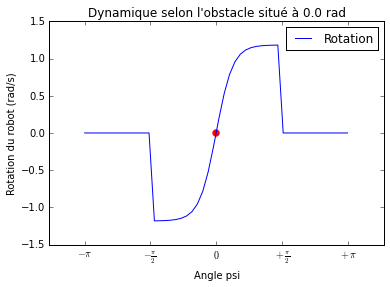

In [67]:
def plotPsi(phi):
    x=np.linspace(-math.pi,math.pi)
    vR = 3/(1+np.exp((-x+phi)*5))-1.5
    for i in range(50):
        if x[i]<-math.pi/2+phi or x[i]>math.pi/2+phi:
            vR[i]=0
    r=20.5
    delta=52
    w=2*r/delta*vR
    plt.plot(x,w, label='Rotation')
    plt.scatter(phi,w[phi], 40, color ='red')
    plt.legend()
    plt.xlabel("Angle psi")
    plt.ylabel("Rotation du robot (rad/s)")
    plt.title("Dynamique selon l'obstacle situé à "+str(phi)+" rad")
    plt.xticks([-math.pi,-math.pi/2, 0, math.pi/2, math.pi],[r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$'])
    plt.show()

slider_phi = widgets.FloatSliderWidget(min=-math.pi/2, max=math.pi/2, step=0.1, value=0)
w=widgets.interactive(plotPsi,phi = slider_phi)
display(w)

###II. Programmation

Pour arriver à ce résulat deux outils ont été utilisés :
* Vrep : simulateur de robot
* DNFPY : le logiciel codant des DNF en python par Benoit


DNFPY utilise un système de map reliée entre elle par parenté. Les racines correspondent au résultat qui fait appel à une classe fille pour les calculs et ainsi de suite.

####1) Hiérarchie des cartes

L'organisation des maps est créé dans la classe ModelEPuckDNF comme suit :

<img SRC="Organigramme.jpeg"
 ALT="Organigramme code"
 TITLE="Organigramme des maps">

####2) La classe VRepSimulator

Cette classe a pour but de servir d'interface entre DNFPY et vrep.

Elle permet d'initialiser une map simulator donc les diverses fonctions sont :
* connection : permet la connexion avec Vrep et le lancement de la simulation
* disconnection : met fin à la connexion et à la simulation
* compute : fait un pas d'itération dans le cas du mode synchrone
* getSensor : récupère les données d'un capteur
* getSensors : récupère les données de plusieurs capteurs
* setController : permet de modifier l'ordre d'un controleur

Voici les diverses commandes associées à Vrep que l'on retrouve dans les fonctions précédentes :

* Connexion et déconnexion :

clientID=vrep.simxStart('127.0.0.1',port,True,True,5000,5)
vrep.simxFinish(clientID)

* Mode synchrone :

vrep.simxSynchronous(clientID,True) #active le mode synchrone
vrep.simxSynchronousTrigger(clientID) #permet de rajouter un pas

* Simulation :

vrep.simxStartSimulation(clientID,vrep.simx_opmode_oneshot_wait)
vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot_wait)

* Permet d'obtenir un handle :
    
errorCode,sensor_handle=vrep.simxGetObjectHandle(clientID,'ePuck_proxSensor1',vrep.simx_opmode_oneshot_wait)


* Appel d'un capteur de proximité :

errorCode,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,sensor_handle,vrep.simx_opmode_streaming)


* Changer la valeur des moteurs :

errorCode=vrep.simxSetJointTargetVelocity(clientID,left_motor_handle,vl, vrep.simx_opmode_streaming)

####3) La classe GetIRSensors

Elle a comme enfant la map VRepSimulator et en récupère les données des capteurs de proximité infrarouge ePuck dans une liste.


####4) La classe MotorProjection

C'est la racine double (pour chaque roue) des maps. 
Elle a comme enfant les maps VRepSimulator et Activation.

Le gros du travail est effectué ici. C'est cette classe qui s'occupe de faire la moyenne pondérée et de la transformer en vitesse grâce à la formule vu dans la première partie.